In [1]:
# !pip install tensorflow-gpu==2.0.0-alpha
# !pip install split-folders

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import tensorflow as tf
import splitfolders
import numpy as np
import cv2
import os


print(os.listdir("data"))

['140k-real-and-fake-faces', 'dataframe.csv', 'dataset', 'deepfake-and-real-images', 'hardfakevsrealfaces', 'real-vs-ai-generated-faces-dataset', 'real_and_fake_face', 'real_and_fake_face_detection']


In [4]:
real = "data/real_and_fake_face_detection/real_and_fake_face/training_real/"
fake = "data/real_and_fake_face_detection/real_and_fake_face/training_fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [5]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    return image[...,::-1]

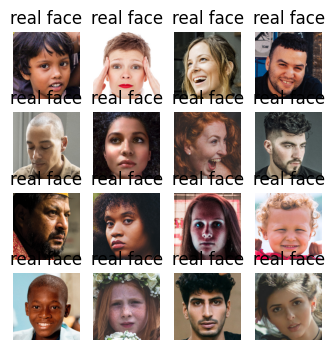

In [6]:
fig = plt.figure(figsize=(4, 4))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.title("real face")
    plt.axis('off')

plt.show()

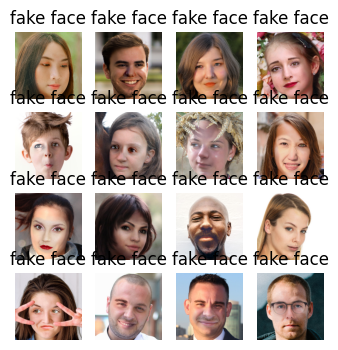

In [7]:
fig = plt.figure(figsize=(4, 4))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.title("fake face")
    plt.axis('off')

plt.show()

In [8]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                   )

In [9]:
dataset_path = "data/real_and_fake_face_detection/real_and_fake_face"

In [10]:
train = train_datagen.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32)

Found 2041 images belonging to 2 classes.


In [11]:
mobilenetV2 = MobileNetV2(input_shape=(96, 96, 3),
                          include_top=False,
                          weights='imagenet'
                          )

average_layer = GlobalAveragePooling2D()

model = Sequential([
    mobilenetV2,
    average_layer,
    Dense(256, activation=tf.nn.relu),
    BatchNormalization(),
    Dropout(0.2),
    Dense(2, activation=tf.nn.softmax)
])

In [12]:
model.compile(optimizer=Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

c:\Users\nico2\.conda\envs\deepcatcher_venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [14]:
model.fit_generator(train,
                    epochs=50,
                    callbacks=[lr_callbacks])

C:\Users\nico2\AppData\Local\Temp\ipykernel_23188\1725852344.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train,


Epoch 1/50
64/64 [==============================] - 29s 317ms/step - loss: 1.1273 - accuracy: 0.5747 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 11s 175ms/step - loss: 0.6887 - accuracy: 0.6580 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 11s 175ms/step - loss: 0.5896 - accuracy: 0.7148 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 11s 171ms/step - loss: 0.4538 - accuracy: 0.7927 - lr: 1.0000e-04
Epoch 5/50
64/64 [==============================] - 11s 171ms/step - loss: 0.3676 - accuracy: 0.8383 - lr: 1.0000e-04
Epoch 6/50
64/64 [==============================] - 11s 171ms/step - loss: 0.3119 - accuracy: 0.8731 - lr: 1.0000e-04
Epoch 7/50
64/64 [==============================] - 11s 172ms/step - loss: 0.2831 - accuracy: 0.8800 - lr: 1.0000e-04
Epoch 8/50
64/64 [==============================] - 11s 171ms/step - loss: 0.2312 - accuracy: 0.9084 - lr: 1.0000e-04
Epoch 9/50
64/64 [==============================] - 11s 170ms/step -

In [15]:
model.evaluate_generator(train)

C:\Users\nico2\AppData\Local\Temp\ipykernel_23188\168570560.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(train)


[0.003109489567577839, 1.0]

In [16]:
model.save("models/model_2.h5")